In [24]:
"""
Gathering the aspen proportions from the LANDFIRE EVT summaries
"""

import os, time, glob, gc
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import dask

from datetime import datetime

import warnings
warnings.filterwarnings("ignore") # suppresses annoying geopandas warning

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [25]:
# Load the data (for events).
events_fp = os.path.join(projdir,'data/spatial/raw/FIRED/fired-events_west_2012_to_2023.gpkg')
events = gpd.read_file(events_fp)
events = events[events['ig_year'] >= 2018] # Work with 2018-> (for Sentinel)
events = events.to_crs(proj) # ensure albers projection
events.columns

Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
       'na_l3name', 'geometry'],
      dtype='object')

In [26]:
# Load the EVT summary table.
events_evt_fp = os.path.join(projdir, 'data/tabular/mod/EVT/fired-events_west_2018_to_2023-EVT.csv')
events_evt = pd.read_csv(events_evt_fp)
events_evt.head()

,Unnamed: 0,id,evt,count,total_pixels,pct_cover,EVT_NAME,EVT_PHYS,EVT_GP_N,EVT_CLASS
0,0,10,7035,14,2678,0.522778,North Pacific Dry Douglas-fir-(Madrone) Forest...,Conifer,Douglas-fir Forest and Woodland,Closed tree canopy
1,1,10,7037,1263,2678,47.162061,North Pacific Maritime Dry-Mesic Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
2,2,10,7039,690,2678,25.765497,North Pacific Maritime Mesic-Wet Douglas-fir-W...,Conifer,Douglas-fir-Western Hemlock Forest and Woodland,Closed tree canopy
3,3,10,7043,562,2678,20.985810,Mediterranean California Mixed Evergreen Forest,Conifer,California Mixed Evergreen Forest and Woodland,Closed tree canopy
4,4,10,7063,36,2678,1.344287,North Pacific Broadleaf Landslide Forest,Hardwood,Red Alder Forest and Woodland,Closed tree canopy


In [ ]:
# Gather aspen classes.

In [27]:
aspen_evt = events_evt[events_evt['EVT_NAME'].str.contains('aspen', case=False, na=False)]['EVT_NAME'].unique()
print(aspen_evt)

['Rocky Mountain Aspen Forest and Woodland'
 'Inter-Mountain Basins Aspen-Mixed Conifer Forest and Woodland'
 'Northwestern Great Plains Aspen Forest and Parkland']


In [28]:
# Now filter to retain wildfire events with at least 1% aspen forest cover
df = events_evt[events_evt['EVT_NAME'].isin(aspen_evt)]
aspen_sum = df.groupby('id')['pct_cover'].sum().reset_index() # get the sum of aspen classes
aspen_sum['pct_aspen'] = aspen_sum['pct_cover']  # rename the column to retain aspen percent

# Filter out fires with less than 5% aspen cover
aspen_events = aspen_sum[aspen_sum['pct_aspen'] >= 1] # retain fires with >= X %
aspen_events = aspen_events[['id','pct_aspen']] # subset columns
print(f"There are [{len(aspen_events)}] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).")

There are [715] fire events with > 1% aspen cover across western U.S. ecoregions (2018-2023).


In [ ]:
# Join back to the events data.

In [33]:
common_ids = set(events['id']).intersection(set(aspen_events['id'])) # Find intersection
print(f"Number of common IDs: {len(common_ids)}")

Number of common IDs: 715


In [30]:
# Join aspen percent to the spatial data.
aspen_events = pd.merge(events, aspen_events, on='id', how='inner')
print(aspen_events.columns)

Index(['id', 'ig_date', 'ig_day', 'ig_month', 'ig_year', 'last_date',
       'event_dur', 'tot_pix', 'tot_ar_km2', 'fsr_px_dy', 'fsr_km2_dy',
       'mx_grw_px', 'mx_grw_km2', 'mx_grw_dte', 'ig_utm_x', 'ig_utm_y',
       'na_l3name', 'geometry', 'pct_aspen'],
      dtype='object')


In [ ]:
# Do some data filtering.

In [34]:
# Filter out fires that are only one MODIS burned area pixel 
aspen_events_ = aspen_events[(aspen_events['tot_pix'] > 1)]
print(aspen_events_['tot_pix'].describe())
print(f'There are {len(aspen_events_)} fire events remaining.')

count     536.000000
mean      101.320896
std       399.035231
min         2.000000
25%         4.000000
50%         8.000000
75%        37.250000
max      4765.000000
Name: tot_pix, dtype: float64
There are 536 fire events remaining.


In [35]:
# Save this file out
aspen_events = aspen_events.to_crs(proj)  # ensure the correct projection before exporting
out_fp = os.path.join(projdir,'data/spatial/mod/FIRED/fired-events_west_2018_to_2024_aspen.gpkg')
aspen_events.to_file(out_fp)
print(f"Saved file to {out_fp}")

Saved file to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/FIRED/fired-events_west_2018_to_2024_aspen.gpkg


In [ ]:
# Map of aspen fires

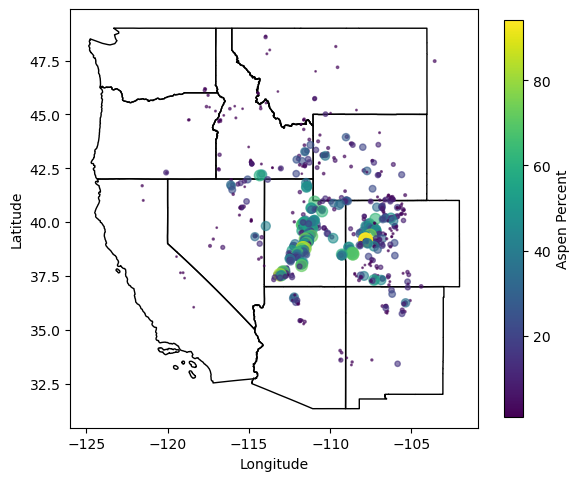

In [36]:
# Load the state boundaries
states = gpd.read_file(os.path.join(maindir,'data/boundaries/political/TIGER/tl19_us_states_west_nad83.gpkg'))
states = states.to_crs(4326)

# Generate centroids
centroid = aspen_events.copy()
centroid = centroid.to_crs(4326)
centroid['geometry'] = centroid.geometry.centroid

# Make a spatial map of the centroids now
fig, ax = plt.subplots(figsize=(6, 6))

states.plot(ax=ax, edgecolor='black', linewidth=1, color='none')

# Plot centroids
centroid['size'] = centroid['pct_aspen'] * 10  # Adjust the scaling factor as necessary
centroid.plot(
    ax=ax, markersize=centroid['pct_aspen'], 
    column='pct_aspen', cmap='viridis', 
    legend=False, alpha=0.6)

# Manually add colorbar
norm = matplotlib.colors.Normalize(vmin=centroid['pct_aspen'].min(), vmax=centroid['pct_aspen'].max())
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])  # Only needed for ScalarMappable

# Adjust the size of the colorbar using the `shrink` parameter
cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
cbar.set_label('Aspen Percent')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Save the map as a PNG
plt.savefig(os.path.join(projdir, 'figures/Fig1_all_aspen_fires.png'), dpi=300, bbox_inches='tight')

plt.show()